In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

1. Load in the csv file. 

In [3]:
df = pd.read_csv('aqi_ny.csv')

2. Drop the extra index.

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. Make the date column the index, and get rid of the extra date column so there's not a duplicate.

In [6]:
df.index = pd.to_datetime(df['date'])

In [7]:
df = df.drop('date', axis=1)

In [8]:
pm25 = df['pm2_5']

4. Visualize your data. 

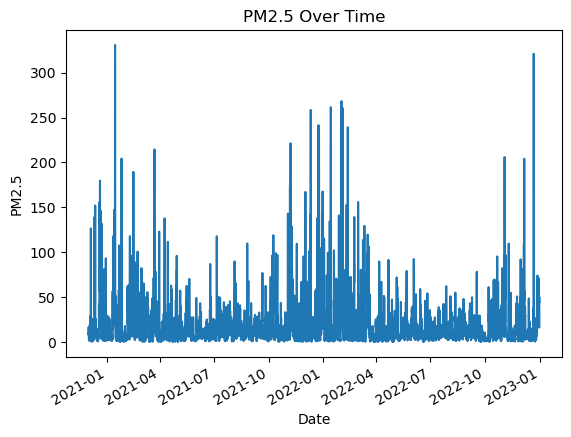

In [9]:
pm25.plot(title= 'PM2.5 Over Time', ylabel = 'PM2.5', xlabel = 'Date');

6. What makes LSTM much better at predicting time series data is that it takes into account a certain amount of values to predict the next one. In this case, the window size is 8, so it is looking at the first 8 values to predict value number 9, next it uses values 2 to 9 to predict 10, and so on. This function gets the data into this format, where X are the predictor values and y is what is being predicted. 

In [10]:
def df_to_X_y(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+8]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

7. This shows us the shape of X and y, for both there are 18056 arrays, but X has 8 lists in each array since our window size is 8, and y only has one since we are predicting one value at a time. 

In [11]:
window_size = 8
X, y = df_to_X_y(pm25, window_size)
X.shape, y.shape

((18053, 8, 1), (18053,))

8. Split the data into a training set, a validation set, and a testing set. 

In [12]:
X_train, y_train = X[:12000], y[:12000]
X_val, y_val = X[12000:15000], y[12000:15000]
X_test, y_test = X[15000:], y[15000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12000, 8, 1), (12000,), (3000, 8, 1), (3000,), (3053, 8, 1), (3053,))

In [13]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam 

9. Create the model. For the first layer you have to specify the shape of your model, since the window size is 8 and we only have one predictor the layer is 8 by 1. Next comes 1 LSTM layer, since LSTM is a neural network you have to specify the number of neurons, 32, 64, 128, and 256 are all common. Two dense layers follow the LSTM layer, the last dense layer is responsible for the regression task, and in this case we specify 1 because we want the output to be 1 predicted value.

In [14]:
model1 = Sequential()
model1.add(InputLayer((8,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


10. Create a checkpoint that saves the best performing model. Just like our XGBoost model, we are using a low learning rate so it will be slower. 

In [15]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

11. Fit the model. The number you choose for your epochs specifies how many times you will run through the data, so the larger the number the longer it will take to run. 

In [16]:
model1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=25, callbacks=[cp])

Epoch 1/25
374/375 [============================>.] - ETA: 0s - loss: 1062.3115 - root_mean_squared_error: 32.5931

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 16s 32ms/step - loss: 1064.2617 - root_mean_squared_error: 32.6230 - val_loss: 236.6974 - val_root_mean_squared_error: 15.3850
Epoch 2/25
371/375 [============================>.] - ETA: 0s - loss: 1048.4120 - root_mean_squared_error: 32.3792

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 24ms/step - loss: 1042.7618 - root_mean_squared_error: 32.2918 - val_loss: 172.7933 - val_root_mean_squared_error: 13.1451
Epoch 3/25
371/375 [============================>.] - ETA: 0s - loss: 865.7863 - root_mean_squared_error: 29.4242

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 27ms/step - loss: 867.7995 - root_mean_squared_error: 29.4584 - val_loss: 93.1760 - val_root_mean_squared_error: 9.6528
Epoch 4/25
375/375 [==============================] - ETA: 0s - loss: 733.9507 - root_mean_squared_error: 27.0915

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 733.9507 - root_mean_squared_error: 27.0915 - val_loss: 62.8862 - val_root_mean_squared_error: 7.9301
Epoch 5/25
369/375 [============================>.] - ETA: 0s - loss: 656.9749 - root_mean_squared_error: 25.6315

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 26ms/step - loss: 653.8276 - root_mean_squared_error: 25.5701 - val_loss: 44.5330 - val_root_mean_squared_error: 6.6733
Epoch 6/25
372/375 [============================>.] - ETA: 0s - loss: 590.7727 - root_mean_squared_error: 24.3058

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 28ms/step - loss: 589.1715 - root_mean_squared_error: 24.2729 - val_loss: 32.7046 - val_root_mean_squared_error: 5.7188
Epoch 7/25
374/375 [============================>.] - ETA: 0s - loss: 533.7883 - root_mean_squared_error: 23.1039

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 26ms/step - loss: 532.8469 - root_mean_squared_error: 23.0835 - val_loss: 24.4677 - val_root_mean_squared_error: 4.9465
Epoch 8/25
369/375 [============================>.] - ETA: 0s - loss: 488.5457 - root_mean_squared_error: 22.1031

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 32ms/step - loss: 482.7941 - root_mean_squared_error: 21.9726 - val_loss: 18.7347 - val_root_mean_squared_error: 4.3284
Epoch 9/25
373/375 [============================>.] - ETA: 0s - loss: 439.4231 - root_mean_squared_error: 20.9624

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 438.0993 - root_mean_squared_error: 20.9308 - val_loss: 14.5238 - val_root_mean_squared_error: 3.8110
Epoch 10/25
371/375 [============================>.] - ETA: 0s - loss: 400.1305 - root_mean_squared_error: 20.0033

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 397.9654 - root_mean_squared_error: 19.9491 - val_loss: 11.5582 - val_root_mean_squared_error: 3.3997
Epoch 11/25
371/375 [============================>.] - ETA: 0s - loss: 361.0363 - root_mean_squared_error: 19.0010

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 361.7869 - root_mean_squared_error: 19.0207 - val_loss: 9.1716 - val_root_mean_squared_error: 3.0285
Epoch 12/25
369/375 [============================>.] - ETA: 0s - loss: 327.1853 - root_mean_squared_error: 18.0883

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 328.4834 - root_mean_squared_error: 18.1241 - val_loss: 7.2615 - val_root_mean_squared_error: 2.6947
Epoch 13/25
368/375 [============================>.] - ETA: 0s - loss: 301.3871 - root_mean_squared_error: 17.3605

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 298.6495 - root_mean_squared_error: 17.2815 - val_loss: 5.6980 - val_root_mean_squared_error: 2.3870
Epoch 14/25
369/375 [============================>.] - ETA: 0s - loss: 271.0313 - root_mean_squared_error: 16.4630

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 27ms/step - loss: 271.5072 - root_mean_squared_error: 16.4775 - val_loss: 4.3946 - val_root_mean_squared_error: 2.0963
Epoch 15/25
375/375 [==============================] - ETA: 0s - loss: 246.9924 - root_mean_squared_error: 15.7160

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 246.9924 - root_mean_squared_error: 15.7160 - val_loss: 3.4836 - val_root_mean_squared_error: 1.8664
Epoch 16/25
372/375 [============================>.] - ETA: 0s - loss: 226.5107 - root_mean_squared_error: 15.0503

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 225.1401 - root_mean_squared_error: 15.0047 - val_loss: 2.6371 - val_root_mean_squared_error: 1.6239
Epoch 17/25
372/375 [============================>.] - ETA: 0s - loss: 205.8602 - root_mean_squared_error: 14.3478

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 25ms/step - loss: 205.2473 - root_mean_squared_error: 14.3265 - val_loss: 2.1276 - val_root_mean_squared_error: 1.4586
Epoch 18/25
372/375 [============================>.] - ETA: 0s - loss: 187.6866 - root_mean_squared_error: 13.6999

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 29ms/step - loss: 187.1602 - root_mean_squared_error: 13.6807 - val_loss: 1.6612 - val_root_mean_squared_error: 1.2889
Epoch 19/25
374/375 [============================>.] - ETA: 0s - loss: 171.1961 - root_mean_squared_error: 13.0842

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 170.7513 - root_mean_squared_error: 13.0672 - val_loss: 1.5933 - val_root_mean_squared_error: 1.2623
Epoch 20/25
371/375 [============================>.] - ETA: 0s - loss: 157.1579 - root_mean_squared_error: 12.5363

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 25ms/step - loss: 155.9501 - root_mean_squared_error: 12.4880 - val_loss: 1.2516 - val_root_mean_squared_error: 1.1188
Epoch 21/25
374/375 [============================>.] - ETA: 0s - loss: 142.2062 - root_mean_squared_error: 11.9250

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 142.4941 - root_mean_squared_error: 11.9371 - val_loss: 1.0464 - val_root_mean_squared_error: 1.0230
Epoch 22/25
373/375 [============================>.] - ETA: 0s - loss: 129.3034 - root_mean_squared_error: 11.3712

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 130.1729 - root_mean_squared_error: 11.4093 - val_loss: 0.9329 - val_root_mean_squared_error: 0.9659
Epoch 23/25
372/375 [============================>.] - ETA: 0s - loss: 118.1736 - root_mean_squared_error: 10.8708

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 32ms/step - loss: 119.0158 - root_mean_squared_error: 10.9094 - val_loss: 0.8887 - val_root_mean_squared_error: 0.9427
Epoch 24/25
369/375 [============================>.] - ETA: 0s - loss: 110.5659 - root_mean_squared_error: 10.5150

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 33ms/step - loss: 108.9635 - root_mean_squared_error: 10.4386 - val_loss: 0.8790 - val_root_mean_squared_error: 0.9376
Epoch 25/25
368/375 [============================>.] - ETA: 0s - loss: 100.7094 - root_mean_squared_error: 10.0354

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 99.7918 - root_mean_squared_error: 9.9896 - val_loss: 0.8054 - val_root_mean_squared_error: 0.8974


In [17]:
from keras.models import load_model

12. Load the model so we can work with the best one. 

In [18]:
model1 = load_model('model1/')

13. Calculate the predicted values for the training set and add them to a dataframe with the actuals.

In [19]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

375/375 [==============================] - 3s 5ms/step


,Train Predictions,Actuals
0,10.423456,10.60
1,12.199368,11.92
2,14.975510,15.04
3,16.813272,16.85
4,16.397938,15.64
...,...,...
11995,2.553524,2.45
11996,2.960152,2.90
11997,3.656843,3.48
11998,4.611125,4.54


14. Visualize the data to compare predicted values to the actual values for the training set. As you can see, the model did a very good job of predicting values since the lines are pretty much on top of each other, but it struggled to predict when the PM2.5 values spiked.

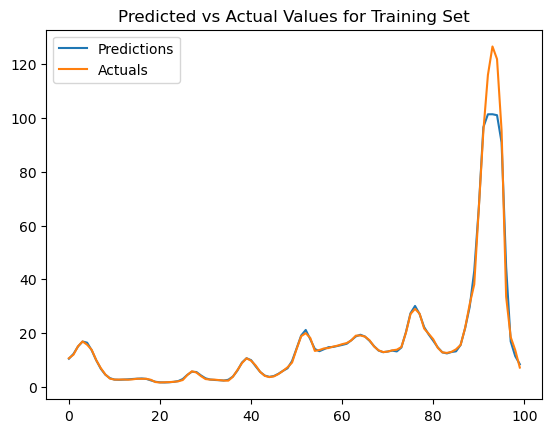

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

15. Calculate the predicted values for the validation set and add them to a dataframe with the actuals.

In [21]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

94/94 [==============================] - 1s 4ms/step


,Val Predictions,Actuals
0,8.496200,7.60
1,11.721306,11.78
2,10.876074,12.08
3,7.546527,5.95
4,6.688907,6.47
...,...,...
2995,20.562735,20.61
2996,19.635715,19.86
2997,18.341402,18.63
2998,17.760826,17.85


16. Visualize the data to compare predicted values to the actual values for the validation set. It looks like the model did a good job, but the predicted values are a little lower when it comes to the big spikes. 

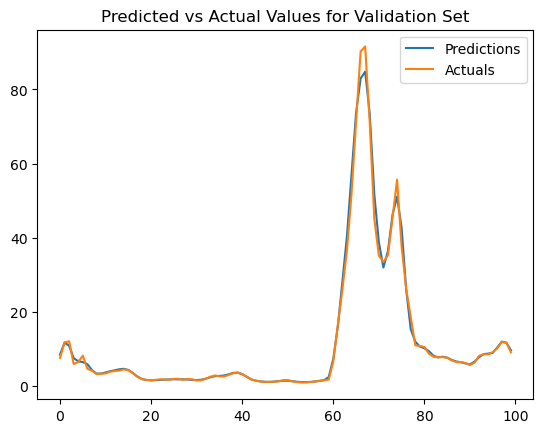

In [22]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

17. Calculate the predicted values for the test set and add them to a dataframe along with the actuals.

In [23]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

96/96 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,18.155226,18.85
1,17.282810,16.84
2,17.248648,17.90
3,19.334585,19.42
4,23.340382,22.37
...,...,...
3048,15.781530,16.50
3049,18.097990,17.82
3050,24.930271,24.86
3051,36.212852,36.08


18. Visualize the data to compare predicted values to the actual values for the test set. This time, it looks like the model overshot the actual values since the predicted line rises above the line for the actuals on the first two spikes. 

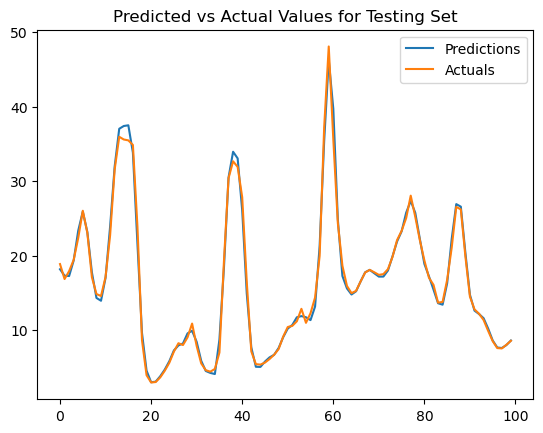

In [24]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Testing Set')
plt.legend(['Predictions','Actuals']);

In [25]:
from sklearn.metrics import r2_score

19. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed pretty well when you consider that we did not have to add any extra features like we had to for the XGBoost model. When we tested the XGBoost model's training score with no added features it was .12, so this model performs much better at its most basic level. 

In [26]:
train_r2 = r2_score(train_results['Actuals'],train_results['Train Predictions'])
train_r2

0.8674939301758736

In [27]:
val_r2 = r2_score(val_results['Actuals'],val_results['Val Predictions'])
val_r2

0.9923640346963105

In [28]:
test_r2 = r2_score(test_results['Actuals'],test_results['Test Predictions'])
test_r2

0.8007693005703918

20. Create a second model. This time we are adding features to help it get a better sense of how the data progresses with time so that its performance is hopefully improved. As we saw before, this is not as necessary as when you use XGBoost to predict time series data, but we want to try and refine our model. 

In [29]:
pm25_df = pd.DataFrame({'pm2_5':pm25})
pm25_df['seconds'] = pm25_df.index.map(pd.Timestamp.timestamp)
pm25_df

,pm2_5,seconds
date,,
2020-12-01 05:00:00,9.31,1.606799e+09
2020-12-01 06:00:00,8.43,1.606802e+09
2020-12-01 07:00:00,8.55,1.606806e+09
2020-12-01 08:00:00,8.92,1.606810e+09
2020-12-01 09:00:00,9.62,1.606813e+09
...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09
2022-12-31 14:00:00,45.75,1.672495e+09
2022-12-31 15:00:00,50.21,1.672499e+09


21. Use the seconds column to create columns for Day sin, Day cos, Year sin, and Year cos. These features are similar to the lag features that we used for our XGBoost model in that they are there to give a sense of relative time, but these are referred to as cyclical features. 

In [30]:
day = 60*60*24
year = 365.2425*day 

pm25_df['Day sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Day cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Year sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / year))
pm25_df['Year cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / year))

In [31]:
pm25_df

,pm2_5,seconds,Day sin,Day cos,Year sin,Year cos
date,,,,,,
2020-12-01 05:00:00,9.31,1.606799e+09,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.606802e+09,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,1.606806e+09,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,1.606810e+09,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,1.606813e+09,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,1.672495e+09,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,1.672499e+09,-0.707107,-7.071068e-01,-0.003914,0.999992


22. Drop the seconds column since it is no longer necessary now that we have created the extra columns. 

In [32]:
aqi_df = pm25_df.drop('seconds', axis=1)

In [33]:
aqi_df

,pm2_5,Day sin,Day cos,Year sin,Year cos
date,,,,,
2020-12-01 05:00:00,9.31,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...
2022-12-31 13:00:00,36.08,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,-0.707107,-7.071068e-01,-0.003914,0.999992


23. This is the same function as before, but it makes it so that there are 8 lists in each array since the window size is 8, and each array has 5 values since we have 5 features now (PM2.5, day sin, day cos, year sin, and year cos).

In [34]:
def df_to_X_y2(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [35]:
X2, y2 = df_to_X_y2(aqi_df)
X2.shape, y2.shape 

((18053, 8, 5), (18053,))

24. Separate the data into a training set, a validation set, and a testing set. 

In [36]:
X2_train, y2_train = X2[:12000], y2[:12000]
X2_val, y2_val = X2[12000:15000], y2[12000:15000]
X2_test, y2_test = X2[15000:], y2[15000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((12000, 8, 5), (12000,), (3000, 8, 5), (3000,), (3053, 8, 5), (3053,))

25. Standardize the data so that all the values are on a similar scale. 

In [37]:
pm25_training_mean = np.mean(X2_train[:, :, 0])
pm25_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - pm25_training_mean) / pm25_training_std
    return X

In [38]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 7.63055244e-02,  9.65925826e-01,  2.58819045e-01,
         -7.79677220e-01, -6.26181629e-01],
        [ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        ...,
        [ 1.07165798e-02,  5.00000000e-01, -8.66025404e-01,
         -7.81916387e-01, -6.23383320e-01],
        [-6.41889762e-02,  2.58819045e-01, -9.65925826e-01,
         -7.82363017e-01, -6.22822696e-01],
        [-2.46865437e-02,  1.20031004e-11, -1.00000000e+00,
         -7.82809244e-01, -6.22261752e-01]],

       [[ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        [-2.65498660e-02,  8.66025404e-01, -5.00000000e-01,
         -7.81021924e-01, -6.24503606e-01],
        ...,
        [-6.41889762e-02,  2.5881904

26. Create the model, everything stays the same as the first attempt but the InputLayer since the dimensions have now changed because we added those extra time features. 

In [39]:
model2 = Sequential()
model2.add(InputLayer((8, 5)))
model2.add(LSTM(64))
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


27. Create the checkpoint to save the best model.

In [40]:
cp2 = ModelCheckpoint('model2/',save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

28. Fit the model.

In [41]:
model2.fit(X2_train,y2_train, validation_data=(X2_val,y2_val), epochs=25, callbacks=[cp2])

Epoch 1/25
375/375 [==============================] - ETA: 0s - loss: 993.8737 - root_mean_squared_error: 31.5258 

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 28ms/step - loss: 993.8737 - root_mean_squared_error: 31.5258 - val_loss: 198.9019 - val_root_mean_squared_error: 14.1033
Epoch 2/25
375/375 [==============================] - ETA: 0s - loss: 685.2429 - root_mean_squared_error: 26.1771

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 685.2429 - root_mean_squared_error: 26.1771 - val_loss: 79.2904 - val_root_mean_squared_error: 8.9045
Epoch 3/25
370/375 [============================>.] - ETA: 0s - loss: 572.1111 - root_mean_squared_error: 23.9188

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 574.8015 - root_mean_squared_error: 23.9750 - val_loss: 76.2505 - val_root_mean_squared_error: 8.7322
Epoch 4/25
371/375 [============================>.] - ETA: 0s - loss: 513.0132 - root_mean_squared_error: 22.6498

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 511.3332 - root_mean_squared_error: 22.6127 - val_loss: 66.6781 - val_root_mean_squared_error: 8.1657
Epoch 5/25
370/375 [============================>.] - ETA: 0s - loss: 454.7275 - root_mean_squared_error: 21.3243

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 28ms/step - loss: 451.3922 - root_mean_squared_error: 21.2460 - val_loss: 55.3766 - val_root_mean_squared_error: 7.4415
Epoch 6/25
370/375 [============================>.] - ETA: 0s - loss: 398.4136 - root_mean_squared_error: 19.9603

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 32ms/step - loss: 395.4445 - root_mean_squared_error: 19.8858 - val_loss: 45.3535 - val_root_mean_squared_error: 6.7345
Epoch 7/25
372/375 [============================>.] - ETA: 0s - loss: 346.1586 - root_mean_squared_error: 18.6053

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 344.6810 - root_mean_squared_error: 18.5656 - val_loss: 38.5790 - val_root_mean_squared_error: 6.2112
Epoch 8/25
374/375 [============================>.] - ETA: 0s - loss: 300.4858 - root_mean_squared_error: 17.3345

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 31ms/step - loss: 300.5496 - root_mean_squared_error: 17.3364 - val_loss: 33.4831 - val_root_mean_squared_error: 5.7865
Epoch 9/25
373/375 [============================>.] - ETA: 0s - loss: 263.6255 - root_mean_squared_error: 16.2365

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 26ms/step - loss: 263.0660 - root_mean_squared_error: 16.2193 - val_loss: 28.6854 - val_root_mean_squared_error: 5.3559
Epoch 10/25
374/375 [============================>.] - ETA: 0s - loss: 231.3999 - root_mean_squared_error: 15.2118

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 230.9759 - root_mean_squared_error: 15.1979 - val_loss: 25.5295 - val_root_mean_squared_error: 5.0527
Epoch 11/25
374/375 [============================>.] - ETA: 0s - loss: 202.7519 - root_mean_squared_error: 14.2391

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 9s 25ms/step - loss: 203.9675 - root_mean_squared_error: 14.2817 - val_loss: 23.1667 - val_root_mean_squared_error: 4.8132
Epoch 12/25
367/375 [============================>.] - ETA: 0s - loss: 183.4066 - root_mean_squared_error: 13.5428

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 25ms/step - loss: 181.5796 - root_mean_squared_error: 13.4751 - val_loss: 20.6327 - val_root_mean_squared_error: 4.5423
Epoch 13/25
374/375 [============================>.] - ETA: 0s - loss: 162.6789 - root_mean_squared_error: 12.7546

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 26ms/step - loss: 162.3411 - root_mean_squared_error: 12.7413 - val_loss: 18.5020 - val_root_mean_squared_error: 4.3014
Epoch 14/25
371/375 [============================>.] - ETA: 0s - loss: 143.8706 - root_mean_squared_error: 11.9946

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 26ms/step - loss: 145.5051 - root_mean_squared_error: 12.0626 - val_loss: 16.9813 - val_root_mean_squared_error: 4.1208
Epoch 15/25
370/375 [============================>.] - ETA: 0s - loss: 130.4159 - root_mean_squared_error: 11.4200

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 32ms/step - loss: 130.8285 - root_mean_squared_error: 11.4380 - val_loss: 15.1858 - val_root_mean_squared_error: 3.8969
Epoch 16/25
371/375 [============================>.] - ETA: 0s - loss: 118.8021 - root_mean_squared_error: 10.8996

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 26ms/step - loss: 118.0059 - root_mean_squared_error: 10.8631 - val_loss: 14.1472 - val_root_mean_squared_error: 3.7613
Epoch 17/25
373/375 [============================>.] - ETA: 0s - loss: 105.2819 - root_mean_squared_error: 10.2607

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 28ms/step - loss: 106.9585 - root_mean_squared_error: 10.3421 - val_loss: 12.9668 - val_root_mean_squared_error: 3.6009
Epoch 18/25
374/375 [============================>.] - ETA: 0s - loss: 97.4274 - root_mean_squared_error: 9.8705

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 97.2035 - root_mean_squared_error: 9.8592 - val_loss: 12.0906 - val_root_mean_squared_error: 3.4772
Epoch 19/25
372/375 [============================>.] - ETA: 0s - loss: 89.2793 - root_mean_squared_error: 9.4488

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 88.7559 - root_mean_squared_error: 9.4210 - val_loss: 11.4969 - val_root_mean_squared_error: 3.3907
Epoch 20/25
369/375 [============================>.] - ETA: 0s - loss: 81.6388 - root_mean_squared_error: 9.0354

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 28ms/step - loss: 81.2031 - root_mean_squared_error: 9.0113 - val_loss: 11.3974 - val_root_mean_squared_error: 3.3760
Epoch 21/25
374/375 [============================>.] - ETA: 0s - loss: 73.6258 - root_mean_squared_error: 8.5805

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 74.6816 - root_mean_squared_error: 8.6419 - val_loss: 10.3713 - val_root_mean_squared_error: 3.2204
Epoch 22/25
373/375 [============================>.] - ETA: 0s - loss: 67.8935 - root_mean_squared_error: 8.2397

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 31ms/step - loss: 68.7323 - root_mean_squared_error: 8.2905 - val_loss: 9.9823 - val_root_mean_squared_error: 3.1595
Epoch 23/25
375/375 [==============================] - ETA: 0s - loss: 63.5392 - root_mean_squared_error: 7.9711

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 34ms/step - loss: 63.5392 - root_mean_squared_error: 7.9711 - val_loss: 9.5849 - val_root_mean_squared_error: 3.0960
Epoch 24/25
370/375 [============================>.] - ETA: 0s - loss: 59.2452 - root_mean_squared_error: 7.6971

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 14s 37ms/step - loss: 59.1016 - root_mean_squared_error: 7.6878 - val_loss: 9.3805 - val_root_mean_squared_error: 3.0628
Epoch 25/25
373/375 [============================>.] - ETA: 0s - loss: 55.2300 - root_mean_squared_error: 7.4317

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 55.1874 - root_mean_squared_error: 7.4288 - val_loss: 9.2209 - val_root_mean_squared_error: 3.0366


29. Load the model so we can work with the best one. 

In [42]:
model2 = load_model('model2/')

30. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [43]:
train_predictions2 = model2.predict(X2_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y2_train})
train_results2

375/375 [==============================] - 3s 6ms/step


,Train Predictions,Actuals
0,17.873972,16.85
1,18.535341,15.64
2,14.584927,13.76
3,11.356527,9.90
4,7.110726,6.93
...,...,...
11995,3.446333,4.54
11996,5.014188,5.91
11997,6.887482,7.60
11998,8.971600,11.78


31. Visualize the data to compare predicted values to the actual values for the training set. Again, the model did a pretty good job of predicting values since the lines are pretty close together, but it seems like it had a harder time predicting the larger spikes. 

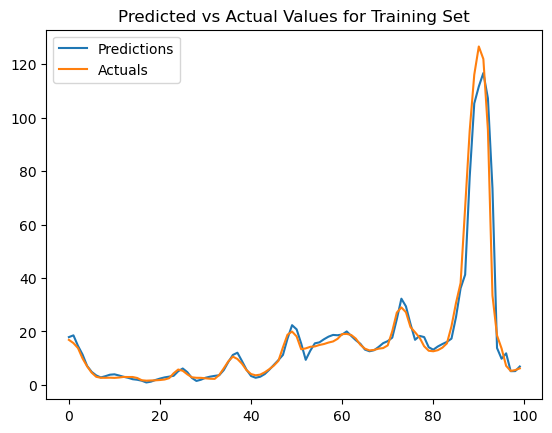

In [44]:
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

32. Calculate the predicted values for the validation set and add them to a dataframe along with the actuals.

In [45]:
val_predictions2 = model2.predict(X2_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions': val_predictions2, 'Actuals': y2_val})
val_results2

94/94 [==============================] - 1s 6ms/step


,Val Predictions,Actuals
0,13.275600,5.95
1,3.794433,6.47
2,5.530428,8.21
3,8.309831,4.67
4,3.313483,4.16
...,...,...
2995,17.495689,17.85
2996,17.310095,18.36
2997,18.682594,18.85
2998,19.540623,16.84


33. Visualize the data to compare predicted values to the actual values for the validation set. For this set, it looks like the model did a little better at predicting that larger spike.

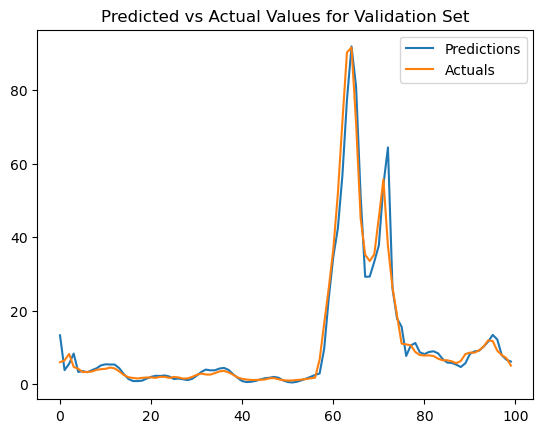

In [46]:
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

34. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [47]:
test_predictions2 = model2.predict(X2_test).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions': test_predictions2, 'Actuals': y2_test})
test_results2

96/96 [==============================] - 1s 7ms/step


,Test Predictions,Actuals
0,18.242033,19.42
1,19.925526,22.37
2,22.964333,26.01
3,26.658348,23.03
4,20.474720,17.09
...,...,...
3048,31.832180,36.08
3049,45.119289,45.75
3050,49.981342,50.21
3051,45.954525,48.14


35. Visualize the data to compare predicted values to the actual values for the testing set. For this set, it looks like the model's predictions overshot the actuals for the larger spikes.

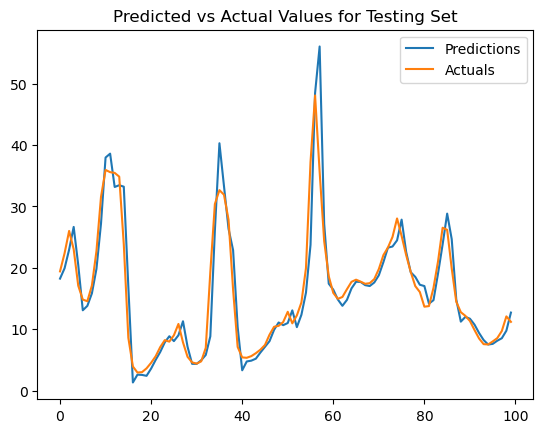

In [48]:
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Testing Set')
plt.legend(['Predictions','Actuals']);

36. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, in general the model performed well. It performed better on the training and testing sets, but it performed worse on the validation set. The first model's values for training and testing were .86 and .80 respectively, and now they are .92 and .89. The coefficient of determination for the last model's validation set was .99 and this model's is .91, which is .09 lower. If you average all three scores for each model you get .88 and .90 respectively, so in general the second model did improve, though the improvement is only by .02. This suggests that time features are not as necessary for predicting time series data with a LSTM model as compared to a XGBoost model. 

In [49]:
train2_r2 = r2_score(train_results2['Actuals'],train_results2['Train Predictions'])
train2_r2

0.9263558724635546

In [50]:
val2_r2 = r2_score(val_results2['Actuals'],val_results2['Val Predictions'])
val2_r2

0.9126026396977276

In [51]:
test2_r2 = r2_score(test_results2['Actuals'],test_results2['Test Predictions'])
test2_r2

0.896015881985729